# Summary of the problem statement 

One of the key challenges of many IT organization are that there Incident Management process is still a manual process
Incidents created by various buisness group needs to be allocated to appropriate person or unit in the support team.

Most of the incidents are initially assigned to Service desk team which is also Known as Service Desk team (L1/L2)

## Some facts

54% of the incidents are resolved by L1&L2 team

56% of the incidents are resolved by L3 team , after being reviewed and forwaded by L1/L2 team.

In Some cases these incidents are directly assigned to L3 team by monitoring tool or callers requestors

## Challenges into manual process

L1/L2 team reviews 25% of incident to follow SOP (Standard operation procedure) , each incident takes 15 Minutes

25% of intial incident assignments by L1/L2 team are faulty, additional effort needed to reassign it to correct group

New incident comes into queue because of reassignments which leads to increased TAT (Turn Around Time) and customer dissatifaction 

1 FTE (full time employee) is required to assign the tickets to L3 Group 


# Expectation from AI solution

The whole of the process is a time consuming and tedious task , which can result in human error and customer dissatisfaction

Assigning the incidents automatically to currect functional Group in L1/L2 itself

Assigning the incidents to L3 directly after studying the pattern 

## Proposed Advantage of AI solution 

Increased customer satisfaction due to good turn Around time 

Cost Saving for the company for reducing the  25-30% wrong assignation and rework associated with it




# Details about the data and dataset files are given in below link,
## https://docs.google.com/spreadsheets/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ/edit#gid=36359002

# Prerequisite

One may need to install below libraries while running the code for first time

In [0]:
# dependencies
!pip install wordcloud
!pip install gensim
!pip install langdetect
!pip install spacy
!python -m spacy download en
!pip install scispacy
!pip install spellchecker
!pip install indexer
!pip install fuzzywuzzy 
!pip install python-Levenshtein
!pip install pyspellchecker
!pip install googletrans

# Loading Libraries

In [2]:
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
from string import punctuation
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import time
import nltk
import spacy
from scispacy.abbreviation import AbbreviationDetector
from nltk.corpus import wordnet
from nltk.corpus import words
import regex
from textblob import TextBlob
from spellchecker import SpellChecker
from langdetect import detect
import json
from wordcloud import WordCloud  #Use Microsoft C++ Builder in case if you face issues in installing this package
from gensim.models import Word2Vec
from gensim import corpora
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from googletrans import Translator




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Default graph settings 

defining the size of graph for a uniform display all along 

In [0]:

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('dark_background')

plotting_config = params = {
                                'legend.fontsize': 'large',
                                'figure.figsize': (20, 10),
                                'axes.labelsize': 'large',
                                'axes.titlesize':'x-large',
                                'xtick.labelsize':'x-large',
                                'ytick.labelsize':'x-large'
                            }

plt.rcParams.update(plotting_config)

# Manual Analysis
## Reason:
### foreign language
### domain specific 
reserved_acronyms  --> Represents the acronyms reserved as part of the given dataset. This list has been derived based on the manual analysis performed on the dataset. So that these acronyms can be effectively handled by the model.

reserved_keywords --> Domain specific keywords which are again specific to this dataset, derived the list by manual analysis. These keywords are necessary to retain on the dataset, even though they are not present as part of english dictionary.

composite_keywords --> Due to the typo on the emails, few common words are clubbed as a single word. This list is used further to extract valid words from these composite list.

foreign language keywords --> more frequent words from the foriegn lanuage requests

common_abbreviation  --> Domain specific abbreviations that are not found as part of general external libraries are listed here.

In [0]:
reserved_acronyms = [
                        'abend',
                        'aerp',
                        'aju',
                        'apac',
                        'api',
                        'apo',
                        'app',
                        'apps',
                        'args',
                        'async',
                        'att',
                        'bapi',
                        'bda',
                        'bex',
                        'bios',
                        'bkwin',
                        'bobj',
                        'chn',
                        'com',
                        'conn',
                        'crm',
                        'dhc',
                        'dhcp',
                        'dgm',
                        'dmvpn',
                        'dns',
                        'dst',
                        'dsw',
                        'emea',
                        'eng',
                        'erp',
                        'etime',
                        'exe',
                        'gmbh',
                        'gsc',
                        'gso',
                        'hana',
                        'hcm',
                        'hex',
                        'hrp',
                        'http',
                        'https',
                        'icode',
                        'impl',
                        'inbox',
                        'info',
                        'iplen',
                        'itype',
                        'jco',
                        'konto',
                        'kpm',
                        'lauacyltoe',
                        'len',
                        'logon',
                        'mfg',
                        'mii',
                        'mpls',
                        'msd',
                        'netch',
                        'obj',
                        'obr',
                        'odbc',
                        'omf',
                        'pcap',
                        'pdf',
                        'plm',
                        'pre',
                        'pte',
                        'qa',
                        'que',
                        'ret',
                        'rfc',
                        'rpc',
                        'rtr',
                        'scf',
                        'scm',
                        'scwx',
                        'seq',
                        'sql',
                        'src',
                        'sto',
                        'sudo',
                        'tcp',
                        'trn',
                        'un',
                        'url',
                        'usb',
                        'vlan',
                        'vm',
                        'vpn'
                    ]

reserved_keywords = [
                        'citrix',
                        'icontrol',
                        'infopath',
                        'iphone',
                        'iterator',
                        'netpath',
                        'netweaver',
                        'programdnty',
                        'symantec',
                        'verizon',
                        'vitalyst',
                        'originals'
                    ]


composite_keywords = [
                        'actionperformed',
                        'activesync',
                        'alwaysupservice',
                        'annotatorlist',
                        'appreciatehub',
                        'assemblyresourcelists',
                        'autorice',
                        'backend',
                        'backorder',
                        'backorderreports',
                        'bapireturnederrorexception',
                        'bluescreen',
                        'cadagent',
                        'channelerror',
                        'checkoutbapi',
                        'checkoutview',
                        'classifiertype',
                        'companycenter',
                        'companyguest',
                        'companysecure',
                        'conferenced',
                        'connectionreset',
                        'corporateaccounting',
                        'createknownaccountssummary',
                        'cybersecurity',
                        'datacenter',
                        'datafile',
                        'dataservices',
                        'datateam',
                        'determinated',
                        'dgmlen',
                        'dhcpack',
                        'dotnet',
                        'downloaddocumentoriginals',
                        'downloader',
                        'evaluationmodels',
                        'eventargs',
                        'eventtypepriority',
                        'exeerp',
                        'foreseeconndirection',
                        'foreseemaliciouscomment',
                        'framdntyework',
                        'generatehash',
                        'getassemblyinfo',
                        'getassemblyinfointernal',
                        'getassignments',
                        'getrawbytes',
                        'getrawdata',
                        'getscriptresourceurl',
                        'getscriptresourceurlimpl',
                        'geturl',
                        'globalengservices',
                        'handlereturnstructure',
                        'handlereturnstructureorreturntableline',
                        'hashtype',
                        'hostname',
                        'httpversion',
                        'includestagesbeforeasyncpoint',
                        'inplant',
                        'internetconnection',
                        'inwarehouse',
                        'iscriptresourcehandler',
                        'iterator',
                        'jcoerpmanager',
                        'locallist',
                        'logfile',
                        'lowercaseurlcorrelation',
                        'mailto',
                        'malware',
                        'markhtyeting',
                        'microsoftonline',
                        'miioperatorqa',
                        'minitab',
                        'modelversion',
                        'mountpoint',
                        'naivebayes',
                        'netbios',
                        'objmod',
                        'omforiginalsexport',
                        'onpageprerendercomplete',
                        'ontologyid',
                        'openorderbook',
                        'outofmemoryexception',
                        'passwordmanager',
                        'passwort',
                        'plmfile',
                        'positiveevaluationthreshold',
                        'powerpoint',
                        'processrequestmain',
                        'ransomware',
                        'rechner',
                        'refererproxycorrelationurl',
                        'registerscripts',
                        'registeruniquescripts',
                        'resourcename',
                        'retrawbytes',
                        'runtimeassembly',
                        'runtimescriptresourcehandler',
                        'samaccountname',
                        'samsung',
                        'sandplant',
                        'screenshot',
                        'scriptmanager',
                        'scriptmanagercontrol',
                        'scriptreference',
                        'scriptresourcehandler',
                        'secureworks',
                        'sharepoint',
                        'shopfloor',
                        'slimware',
                        'solarwind',
                        'standalone',
                        'startpassword',
                        'systemadministrator',
                        'tcplen',
                        'teamviewer',
                        'thecomputer',
                        'timeout',
                        'uninstallation',
                        'uninstaller',
                        'uninstalling',
                        'uniquescripts',
                        'urlcorrelation',
                        'urlpath',
                        'userid',
                        'username',
                        'usersettings',
                        'vendorreference',
                        'vendorversion',
                        'virtualcenter',
                        'vitalyst',
                        'vmware'
                    ]

foreign_laguage_keywords = [
                                'defekt',
                                'fehler',
                                'gesperrt',
                                'markhtyeting',
                                'ordner',
                                'vertraulich',
                                'nwfodmhc',
                                'zugriff'
                            ]

common_abbreviation = {
                        'ack': 'acknowledge',
                        'admin': 'administrator',
                        'dly': 'delay',
                        'emp': 'employee',
                        'ltd': 'limited',
                        'mbytes': 'mega bytes',
                        'pls': 'please',
                        'sys': 'system',
                        'pwd': 'password',
                        'wkly': 'weekly',
                        'org': 'organization',
                        'owa': 'outlook web application',
                        'ooo': 'out of office',
                        'qty': 'quantity'
                      }

# initial setup for text-processing, creating an english vocab
# find corpora @ http://www.nltk.org/nltk_data/
# Initialization of requried variables

In [5]:
import nltk
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:

words_corpus = set(w.lower() for w in words.words())
wordnet_corpus = set(w.lower() for w in wordnet.words())
english_vocab = words_corpus.union(wordnet_corpus).union(reserved_acronyms).union(reserved_keywords)
ISO_LANGUAGE_CODES = {x['alpha2']: x['English'].split(';')[0] 
                      for x in list(pd.read_csv('https://raw.githubusercontent.com/mohanrajvanjiappan/Capstone/master/language_codes.csv').T.to_dict().values())}
language_to_code = {val: key for key, val in ISO_LANGUAGE_CODES.items()}
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
word_dict = {}
nlp = spacy.load('en')
nlp.max_length = 1117616
abv = AbbreviationDetector(nlp)
nlp.add_pipe(abv)
entity_recognizer = None
text_blob = None
bad_words = []
corrections = []
spell_checker = {}

In [0]:
try:
    spelling_corrections = pd.read_pickle('spell_check.pkl')
    for i in range(spelling_corrections.shape[0]):
        spell_checker[spelling_corrections.iloc[i, 0]] = spelling_corrections.iloc[i, 1]
except:
    spell_checker = {}

### Reading the dataset given and visualizing the head of data

In [8]:
# read dataset
data = pd.read_csv('https://raw.githubusercontent.com/mohanrajvanjiappan/Capstone/master/incidents.csv', encoding='utf-8')
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


### Reusable functions are written in the below block. 


In [0]:
# library code

def get_caller():
    stack = inspect.stack()
    caller = stack[3].code_context[0].split(r'(')[0].split()[-1]
    caller = ' '.join(list(map(lambda x: x.capitalize(), caller.split('_'))))
    return caller


def status_evaluator(return_value, start_time, end_time):
    """
        returns true or false after validating function response
    """
    try:
        status_is_good = True
        time_lapsed = round(end_time - start_time, 3)
        caller = get_caller()
        indicator = '\u274C'  # indicates bad status
        
        for value in return_value:
            try:
                if not value[1]:
                    status_is_good = value[1]  # evaluates to false
                    break
            except Exception as e:
                status_is_good = False
                raise ValueError(f'Status evaluator crashed | Err Msg={e}')
                
        if status_is_good:
            indicator = '\u2705'  # indicates good status

        time_lapsed = f'{"*"*10} {caller} | [ Lapsed: {time_lapsed} seconds ] {"*"*10}'
        status = f'{"*"*10} {caller} | [ Status: {indicator} ] {"*"*10}'
        print(status)
        print(time_lapsed)
        print()
    except Exception as e:
        raise e

def run_with_concurrent_threads(function):
    def wrapper(*args, **kwargs):
        # extract params
        if kwargs.get('retrieve_errors') is None:
            kwargs['retrieve_errors'] = False
            
        if kwargs.get('threaded_run') is None:
            kwargs['threaded_run'] = True
        
        if kwargs.get('max_workers') is None:
            kwargs['max_workers'] = 8
        
        if kwargs.get('silent_run') is None:
            kwargs['silent_run'] = False
            
        
        # initiate caller
        start_time = time.time()
        if bool(kwargs.get('threaded_run')):
            max_workers = kwargs.get('max_workers')
            with ThreadPoolExecutor(max_workers=max_workers) as t:
                rv = list(t.map(partial(function, **kwargs), *args))
        else:
            rv = list(map(partial(function, **kwargs), args))
        end_time = time.time()
        
        # evaluate execution status
        if not bool(kwargs.get('silent_run')):
            status_evaluator(rv, start_time, end_time)
        results = list(map(lambda x: x[0], rv))
        
        # retrieve error stack
        if bool(kwargs.get('retrieve_errors')):
            errors = list(map(lambda x: x[2], list(filter(lambda x: bool(x[2]), rv))))
            if bool(errors):
                print(f'{"*"*10} Error Stack {"*"*10}')
                print(json.dumps(errors, indent=4))
        
        if not bool(kwargs.get('threaded_run')):
            results = results[0]
            
        return results
    return wrapper
 
def is_data_null(data):
    return (data in [None, np.NaN, np.nan]) or (not bool(data))


def drop_unnamed_columns(data):
    target_columns = list(filter(lambda x: not('unnamed' in x.lower()), data.columns))
    return data[target_columns]


def clean_data_columns(data):
    data.columns = list(map(lambda x: x.lower().replace(' ', '_'), data.columns))
    return data


def remove_extra_spaces(text):
    return re.sub(r'\s{2,}', ' ', text).strip()


def remove_special_chars(text):
    try:
        text = ' '.join(re.findall(r'\w+', text)).lower()
        for char in punctuation:
            if char in text:
                text = re.sub(char, ' ', text)
        text = text.replace('\n', '').replace('\r', '').replace('\t', '')
        text = remove_extra_spaces(text)
    except Exception as e:
        e = f'Special character remover crashed at text: {text} | Err Msg={e}'
        raise e
    return text
    
        
def get_all_possible_words(complex_word):
    words_detected = []
    try:
        for i in range(len(complex_word)):
            current_char = complex_word[i] # pick the first
            for j in range(i+1, len(complex_word)):
                other_chars = complex_word[i+1:j+1]
                possible_word = current_char + other_chars
                if possible_word in english_vocab:
                    words_detected.append(possible_word)
    except Exception as e:
        raise ValueError(e)
    return words_detected


def get_most_frequent_item(array):
    try:
        if type(array) is not list:
            array = list(array)
        return max(array, key=array.count) 
    except Exception as e:
        print(f'Failed to extract most frequent item from: {array} | Err msg={e}')
    
    
def get_wordnet_pos_tag(word):
    pos = None
    try:
        synsets = list(map(lambda x: x.name().split('.'), wordnet.synsets(word)))
        if bool(synsets):
            tags = list(map(lambda x: x[1], synsets))
            pos = get_most_frequent_item(tags)
    except Exception as e:
        e = f'Wordnet POS tagger crashed at word: {word} | Err Msg={e}'
        raise ValueError(e)
    return pos


def get_default_pos_tag(word):
    supperted_tags = [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]
    expected_tags =[ 'n', 'v', 'j', 'r']
    pos_tag_map = dict(zip(expected_tags, supperted_tags))
    pos = None
    try:
        # nltk.pos_tag return something like 'NN', 'VB'
        # convert them to tags supported by wordnet like: 'n', 'v'
        nltk_pos_tag = nltk.pos_tag([word])[0][1].lower()[0]
        pos = pos_tag_map.get(nltk_pos_tag)
    except Exception as e:
        e = f'Default POS tagger crashed at word: {word} | Err Msg={e}'
        raise ValueError(e)
    return pos
    

def get_pos_tag(word):
    # default return value will be: 'n' for NOUN
    pos = None
    try:
        pos = get_wordnet_pos_tag(word)
        if pos is None or pos not in 'nvjr':
            pos = get_default_pos_tag(word)
    except ValueError as e:
        pos = get_default_pos_tag(word)
    except Exception as e:
        e = f'POS tagger crashed at word: {word} | Err Msg={e}'
    return pos or 'n'


def get_all_possible_words(complex_word):
    words_detected = []
    try:
        complex_word = remove_special_chars(complex_word).replace(' ', '')
        for i in range(len(complex_word)):
            current_char = complex_word[i]  # pick the first char
            for j in range(i+1, len(complex_word)):
                other_chars = complex_word[i+1:j+1]  # pick all other chars
                possible_word = current_char + other_chars  # form all possible combinations
                if possible_word in english_vocab:
                    words_detected.append(possible_word)
        words_detected = set(words_detected)
    except Exception as e:
        print(f'All possible words generator crashed, Err Msg={e}')
    return words_detected


def get_char_map(complex_word, word_list=None, sort=True, reverse=True):
    char_map = {}
    try:
        if not bool(word_list):
            word_list = get_all_possible_words(complex_word)
        complex_word = remove_special_chars(complex_word).replace(' ', '')
        for char in set(complex_word):
            if char not in char_map:
                words_by_char = set(list(filter(lambda x: x.startswith(char), word_list)))
                if sort:
                    words_by_char = sorted(words_by_char, key=len, reverse=reverse)
                char_map[char] = words_by_char
    except Exception as e:
        print(f'Char map generator crashed, Err Msg={e}')
    return char_map


def extract_possible_words(complex_word, char_map=None, word_list=None):
    extracted_words = []
    try:
        if word_list is None:
            word_list = get_all_possible_words(complex_word)
        if not bool(char_map):
            char_map  = get_char_map(complex_word, word_list=word_list)
        
        target_word = remove_special_chars(complex_word).replace(' ', '')
        for i in range(len(complex_word)):
            first_char = target_word[0]
            possible_words = char_map.get(first_char)
            if bool(possible_words):
                for word in possible_words:
                    if target_word.startswith(word):
                        if word not in extracted_words:
                            extracted_words.append(word)
                            target_word = target_word[len(word):]
                            break
#                       else:
#                           target_word = target_word[len(word):]
            else:
                target_word = target_word[1:]
            if len(target_word) <= 1:
                break
    except Exception as e:
        print(f'Words extractor crashed, Err Msg={e}')
    return extracted_words

    
@run_with_concurrent_threads
def detect_language(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    # try and detect language if text doesn't seem to be english
    status, err_stack = True, []
    language_detected = 'english'
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            if type(text) is str:
                text = set(re.findall(r'[a-zA-Z]+', text))
            if type(text) not in [list, set, tuple]:
                raise ValueError(f'Data must be String type for language detection, but found: {type(text)}')
                
            if bool(text):
                if not any(x in english_vocab for x in text):
                    predictions = []
                    for word in text:
                        try:
                            predicted_language_code = detect(word)
                            predicted_language = ISO_LANGUAGE_CODES.get(predicted_language_code, '').lower()
                            predictions.append(predicted_language)
                        except Exception as e:
                            predictions.append('unknown')
                    if 'unknown' in predictions:
                        language_detected = 'unknown'
                    else:
                        language_detected = get_most_frequent_item(predictions)
    except Exception as e:
        language_detected = 'unknown'
        e = f'Langage detector crashed for text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [language_detected, status, err_stack]
    
    
@run_with_concurrent_threads
def spot_bad_words(text, bad_words=[], retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    # try and spot spelling errors & words not available in english vocabulary
    status, err_stack = True, []
    bad_words, language = [], None
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            if type(text) is str:
                language = detect_language(text, threaded_run=False, silent_run=True)
                text = set(text.split())
            if type(text) not in [list, tuple, set]:
                raise ValueError(f'Can not spot bad words in text: {text}, data type is not iterable: {type(text)}')
            if language == 'english':
                for word in text:
                    bad_word = None
                    if word not in bad_words:
                        if not(word.isalpha() and word in english_vocab) or word in bad_words:
                            bad_word = word
                    if bad_word is not None:
                        bad_words.append(bad_word)
    except Exception as e:
        e = f'Bad Word Spotter Crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [bad_words, status, err_stack]
    
    
@run_with_concurrent_threads
def email_stripper(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    email_pattern = r'([\w|\d|\.|\_|\-|\@]+@\w+\.\w+)'
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            emails_found = re.findall(email_pattern, text)
            if bool(emails_found):
                for email in emails_found:
                    text = text.replace(email, '')
            text = remove_extra_spaces(text)
    except Exception as e:
        e = f'Email stripper crashed, returning original text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def text_cleaner(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = remove_special_chars(text)
            text = remove_extra_spaces(text)
    except Exception as e:
        e = f'Text cleaner crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]

  
@run_with_concurrent_threads    
def greeting_stripper(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    single_syllable_greeting = r'\b(h(i+(e*y*a*o*)|e+(l{2,}o+|y*a*o*)|ola*|allo))\b'
    multi_syllable_greeting = r'\b(good\s*(morning|evening|after\s*noon))\b'
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            acceptable_words = []
            for each_word in text.split():
                word_is_not_a_greeting = not bool(re.match(single_syllable_greeting, each_word))
                if word_is_not_a_greeting:
                    acceptable_words.append(each_word)
                    
            text = ' '.join(acceptable_words)
            
            remaining_greetings = list(map(lambda x: x[0], re.findall(multi_syllable_greeting, text)))
            if bool(remaining_greetings):
                for greeting in remaining_greetings:
                    text = text.replace(greeting, '')
            text = re.sub(r'\s{2,}', ' ', text)
    except Exception as e:
        e = f'Greetings stripper crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def digit_stripper(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = ' '.join(list(filter(lambda x: x.isalpha(), text.split())))
    except Exception as e:
        e = f'Digit stripper cashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def tag_text_with_pos(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    tagged_words = []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = remove_special_chars(text)
            for each_word in text.split():
                pos = get_pos_tag(each_word)
                tagged_words.append((each_word, pos))  
    except Exception as e:
        e = f'POS tagger crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [tagged_words, status, err_stack]


@run_with_concurrent_threads
def lemmatize_text(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = remove_special_chars(text)
            text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x, pos=get_pos_tag(x)),  text.split())))
    except Exception as e:
        e = f'Lemmatier crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def remove_stop_words(text, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = ' '.join(set(text.split()).difference(stopwords))
    except Exception as e:
        e = f'Stop words remover crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def remove_short_words(text, min_len=3, retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = ' '.join(list(filter(lambda x: len(x) >= min_len, text.split())))
    except Exception as e:
        e = f'Short word remover crashed as text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def remove_user_ids(text, user_ids=[], retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    status, err_stack = True, []
    try:
        user_ids = (' '.join(set(user_ids))).split()
        text_is_not_null = not is_data_null(text)
        if text_is_not_null:
            text = remove_special_chars(text)
            # detect bad words
            bad_words = spot_bad_words(text, threaded_run=False, silent_run=True)
            if bool(bad_words):
                for word in bad_words:
                    if word in user_ids:
                        text = re.sub(word, '', text)
            text = remove_extra_spaces(text)
    except Exception as e:
        e = f'Spell checker crashed at text: {text} | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [text, status, err_stack]


@run_with_concurrent_threads
def test(text):
    return text, True



# EDA - Exploratorty Data Analysis

In [10]:
# cleaning up the column names
# turning column names into lower case
# separated by underscore
data = drop_unnamed_columns(data)
data = clean_data_columns(data)
data.columns

Index(['short_description', 'description', 'caller', 'assignment_group'], dtype='object')

In [11]:
# looking for missing values
data.isna().sum().to_frame().T

,short_description,description,caller,assignment_group
0,2,1,0,0


In [12]:
# we can see short_description has 8 missing values
# same way description also has a missing value
# let's take a look at those missing values
data[data.isna().any(axis=1)]

,short_description,description,caller,assignment_group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [13]:
# dropping missing values for the time being
# and validating for missing values again
# data = data.dropna()
data.isna().sum().to_frame().T

,short_description,description,caller,assignment_group
0,2,1,0,0


# Cleaning up the data

First the data is cleaned with Email stripper since the email address is not required for the data analysis and modelling
Further the text is cleaned by removing unnecessary characters
The Greetings are cleaned by calling Greeting Stripper function
on Futher analysis found that digits are not required hence they are removed
Then the stop words are removed to do proper analysis on the frequent words analysis
After removal of short words the text is lemmatized, user id related data is removed
Then detect language is applied to check what are the non english languages are present on the given input dataset.

In [14]:
# detecting language
# this is going to help us spot some odd entries
data['language'] = detect_language(data.description)

********** Detect Language | [ Status: ✅ ] **********
********** Detect Language | [ Lapsed: 2.954 seconds ] **********



In [0]:
translator = Translator()
data['description'] = data.apply(lambda x: translator.translate(x['description']).text if x.language!='english' else x['description'] ,axis = 1)
data['short_description'] = data.apply(lambda x: translator.translate(x['short_description']).text if x.language!='english' else x['short_description'] ,axis = 1)

In [16]:
# text cleaning
# stripping emails
data['cleaner_short_description'] = email_stripper(data.short_description)
data['cleaner_description'] = email_stripper(data.description)

# stripping special chars
data['cleaner_short_description'] = text_cleaner(data.cleaner_short_description)
data['cleaner_description'] = text_cleaner(data.cleaner_description)

# stripping greetings
data['cleaner_short_description'] = greeting_stripper(data.cleaner_short_description)
data['cleaner_description'] = greeting_stripper(data.cleaner_description)

# stripping words that contain digits
data['cleaner_short_description'] = digit_stripper(data.cleaner_short_description)
data['cleaner_description'] = digit_stripper(data.cleaner_description)

# getting rid of un-important words
data['cleaner_short_description'] = remove_stop_words(data.cleaner_short_description)
data['cleaner_description'] = remove_stop_words(data.cleaner_description)

# getting rid of short words
data['cleaner_short_description'] = remove_short_words(data.cleaner_short_description)
data['cleaner_description'] = remove_short_words(data.cleaner_description)

# converting words into their base form
data['cleaner_short_description'] = lemmatize_text(data.cleaner_short_description)
data['cleaner_description'] = lemmatize_text(data.cleaner_description)

# get rid of user ids
data['cleaner_short_description'] = remove_user_ids(data.cleaner_short_description, user_ids=data.caller)
data['cleaner_description'] = remove_user_ids(data.cleaner_description, user_ids=data.caller)


********** Email Stripper | [ Status: ✅ ] **********
********** Email Stripper | [ Lapsed: 1.084 seconds ] **********

********** Email Stripper | [ Status: ✅ ] **********
********** Email Stripper | [ Lapsed: 0.771 seconds ] **********

********** Text Cleaner | [ Status: ✅ ] **********
********** Text Cleaner | [ Lapsed: 1.08 seconds ] **********

********** Text Cleaner | [ Status: ✅ ] **********
********** Text Cleaner | [ Lapsed: 1.322 seconds ] **********

********** Greeting Stripper | [ Status: ✅ ] **********
********** Greeting Stripper | [ Lapsed: 1.275 seconds ] **********

********** Greeting Stripper | [ Status: ✅ ] **********
********** Greeting Stripper | [ Lapsed: 1.313 seconds ] **********

********** Digit Stripper | [ Status: ✅ ] **********
********** Digit Stripper | [ Lapsed: 0.804 seconds ] **********

********** Digit Stripper | [ Status: ✅ ] **********
********** Digit Stripper | [ Lapsed: 1.11 seconds ] **********

********** Remove Stop Words | [ Status: ✅ ] *

In [17]:
# let's have a look what the data look like now
data.head()

,short_description,description,caller,assignment_group,language,cleaner_short_description,cleaner_description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,english,issue login,details advised caller resolved password issue...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,english,outlook,meetings appearing skype correct etc please ou...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,english,vpn log cant,vpn log cannot received best
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,english,tool page access unable,tool page access unable
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,english,error skype,error skype


In [18]:
# text looks a lot cleaner now
# let's try and check for missing values
data.isna().sum().to_frame().T

,short_description,description,caller,assignment_group,language,cleaner_short_description,cleaner_description
0,2,1,0,0,0,2,1


In [19]:
# we can see that short_description has two missing data points
# and description only has one
# this is a very small number, we can just get rid of them for now
data.dropna(inplace=True)
data.isna().sum().to_frame().T

,short_description,description,caller,assignment_group,language,cleaner_short_description,cleaner_description
0,0,0,0,0,0,0,0


# Merging short and long description
After merging the short & Long description it's defined as additional column on the data, so that further analysis can be made on the merged text.

In [20]:
# since we have no more missing values
# extracting feature columns from data
# merging short & long description
# tokenizing text
# data = data[['cleaner_short_description', 'cleaner_description', 'assignment_group', 'language']]
data['merged_text'] = data.apply(lambda x: f'{x.cleaner_short_description} {x.cleaner_description}', axis=1)
data.head()

,short_description,description,caller,assignment_group,language,cleaner_short_description,cleaner_description,merged_text
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,english,issue login,details advised caller resolved password issue...,issue login details advised caller resolved pa...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,english,outlook,meetings appearing skype correct etc please ou...,outlook meetings appearing skype correct etc p...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,english,vpn log cant,vpn log cannot received best,vpn log cant vpn log cannot received best
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,english,tool page access unable,tool page access unable,tool page access unable tool page access unable
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,english,error skype,error skype,error skype error skype


# Finding unusual words
As part of this process the stop bad words are moved and then entities are recognized to understand more about the input data.
Incorrect spelled words are corrected with external libraries.
Then spell check is applied to get valid words.

In [21]:
# trying to correct typos now
# spot unsual words
data['unusual_words'] = spot_bad_words(data.merged_text.values)
if not bool(bad_words):
    for words in data.unusual_words.values:
        for word in words:
            if word not in bad_words:
                bad_words.append(word)

********** Spot Bad Words | [ Status: ✅ ] **********
********** Spot Bad Words | [ Lapsed: 4.063 seconds ] **********



In [22]:
print(f'Total bad words that still remain: {len(bad_words)}')

Total bad words that still remain: 7400


In [0]:
# as we can observe there're some unsual words still left
# now we can perform another round of testing
if entity_recognizer is None:
    entity_recognizer = nlp(data.merged_text.str.cat(sep=' '))
    
if text_blob is None:
    text_blob = TextBlob(data.merged_text.str.cat(sep=' '))

In [0]:
# entity_recognizer = nlp(data.merged_text.str.cat(sep=' '))

def get_entity_type(word, recognizer=None):
    entity_type  = None
    try:
        if recognizer is None:
            recognizer = entity_recognizer
        relevant_entities = list(filter(lambda x: x.text == word, recognizer.ents))
        relevant_labels = list(map(lambda x: x.label_, relevant_entities))
        if bool(relevant_labels):
            entity_type = get_most_frequent_item(relevant_labels)
    except Exception as e:
        print(f'Entity recognizer crashed: {e}')
    return entity_type


def correct_spelling(word):
    correction = None
    try:
        if word in reserved_keywords or word in foreign_laguage_keywords:
            correction = word
        else:
            language = detect_language(word, threaded_run=False, silent_run=True)
            if language == 'english':
                if word not in composite_keywords:
                    entity_type = get_entity_type(word)  # check if it's a named entity
                    if entity_type not in ['ORG', 'PRODUCT']:  # if entity is not an organization/product
                        text_blob = str(TextBlob(word).correct())  # what does text blob say
                        if text_blob != word:
                            correction = text_blob
                        else:
                            spell_check = SpellChecker().correction(word)   # ask spellchecker
                            if spell_check != word:
                                correction = spell_check
                    else:
                        correction = word
            else:
                correction = word
    except Exception as e:
        correction = word
        raise ValueError(e)
    return correction
        

In [0]:
@run_with_concurrent_threads
def run_spell_check(bad_word, user_ids=[], retrieve_errors=False, threaded_run=True, max_workers=16, silent_run=False):
    correction, status, err_stack = None, True, []
    try:
        print(f'{bad_words.index(bad_word)}/{len(bad_words)}', end='\r')
        user_ids = (' '.join(set(user_ids))).split()
        if bool(bad_word):
            word = bad_word
            if word in common_abbreviation:
                correction = common_abbreviation.get(word)
            else:
                if word in user_ids:  # get rid of any user id that may exist
                    correction = ''
                else:
                    correction = correct_spelling(word)
                    if correction is None:
                        if word in composite_keywords:
                            possible_words = extract_possible_words(word)
                            if bool(possible_words):
                                usable_words = possible_words
                                if bool(usable_words):
                                    manual_correction = ' '.join(usable_words)
                                    if word.startswith(manual_correction[:2]):
                                        correction = manual_correction   
            if correction is None:
                correction = ''
    except Exception as e:
        correction = bad_word
        e = f'Spell checker crashed | Err Msg={e}'
        status = False
        err_stack.append(e)
    return [correction, status, err_stack]


def update_spell_checker(bad_words, user_ids=[]):
    total = len(bad_words)
    for i in range(total):
        word = bad_words[i]
        if word not in spell_checker:
            spell_checker[word] = run_spell_check(word, user_ids=user_ids, threaded_run=False, silent_run=True)
        print(f'{i+1} / {total}', end='\r')
    return spell_checker
    
    

In [26]:
### **** this can take a few hours ****
### get rid of foreign language words, to save some time
if not bool(spell_checker):
    spell_checker = update_spell_checker(bad_words, user_ids=data.caller.values)

In [27]:
# correcting spelling errors
for i in range(data.shape[0]):
    print(f'{i+1} / {data.shape[0]}', end='\r')
    if i in data.index:
        text = data.loc[i, 'merged_text']
        language = data.loc[i, 'language']
        bad_words = data.loc[i, 'unusual_words']
        for word in bad_words:
            text = re.sub(r'\b{}\b'.format(word), spell_checker.get(word, word), text)
        data.loc[i, 'merged_text'] = text

In [0]:
# for all the words that we can not correct, we'll let them be
# most of the composite words have been split into more meaningful words
# foreign language words have been left untouched
# now creating tokens and taking a data dump
data['tokenized_text'] = data.merged_text.apply(lambda x: x.split())

After the text preprocessing is done, then the data is exported as pkl file, so that the further process can utilize it straight forward.

In [0]:
# taking a final dump of the data
data.to_pickle('cleaned_data.pkl')

In [0]:
# structure of the data:
"""
    - data is divided into 4 columns, namely: short_description, description, caller, assignment_group
    - short_description: one line summary of the issue that the user is facing
    - description: a more detailed overview of the issue
    - caller: unique id of the person raising the request
    - assignment_group: unique id of the group that handled the request
    - here assignment_group is going to be the target column, and rest can be used to generate feature set
"""

# inconsistencies in data
"""
    - short_description can at times be as short as one word
    - description in some cases is same as short description
    - description is filled with special chars, email ids & user ids etc
    - a lot of entries do not convey much information but are very long
    - a few entries are in some non-english languages
    - a lot of numerical data is also present in description field
    - a few data points are null or don't make sense at all
"""

pass

In [0]:
# NLTK POS Tags

# CC coordinating conjunction
# CD cardinal digit
# DT determiner
# EX existential there (like: “there is” … think of it like “there exists”)
# FW foreign word
# IN preposition/subordinating conjunction
# JJ adjective ‘big’
# JJR adjective, comparative ‘bigger’
# JJS adjective, superlative ‘biggest’
# LS list marker 1)
# MD modal could, will
# NN noun, singular ‘desk’
# NNS noun plural ‘desks’
# NNP proper noun, singular ‘Harrison’
# NNPS proper noun, plural ‘Americans’
# PDT predeterminer ‘all the kids’
# POS possessive ending parent’s
# PRP personal pronoun I, he, she
# PRP$ possessive pronoun my, his, hers
# RB adverb very, silently,
# RBR adverb, comparative better
# RBS adverb, superlative best
# RP particle give up
# TO, to go ‘to’ the store.
# UH interjection, errrrrrrrm
# VB verb, base form take
# VBD verb, past tense took
# VBG verb, gerund/present participle taking
# VBN verb, past participle taken
# VBP verb, sing. present, non-3d take
# VBZ verb, 3rd person sing. present takes
# WDT wh-determiner which
# WP wh-pronoun who, what
# WP$ possessive wh-pronoun whose
# WRB wh-abverb where, when

In [0]:
data.to_csv("cleaned_data.csv")

In [0]:
from google.colab import files
files.download("cleaned_data.pkl")

In [37]:
data['language_afterTranslation'] = detect_language(data.description)

********** Detect Language | [ Status: ✅ ] **********
********** Detect Language | [ Lapsed: 1.336 seconds ] **********



In [41]:
data['language_afterTranslation'].value_counts()

english       8484
welsh            4
french           1
swedish          1
somali           1
slovenian        1
german           1
portuguese       1
swahili          1
afrikaans        1
turkish          1
Name: language_afterTranslation, dtype: int64

Majority of the data is translated to English using Google Translator API.



# 8. Number of tickets per group

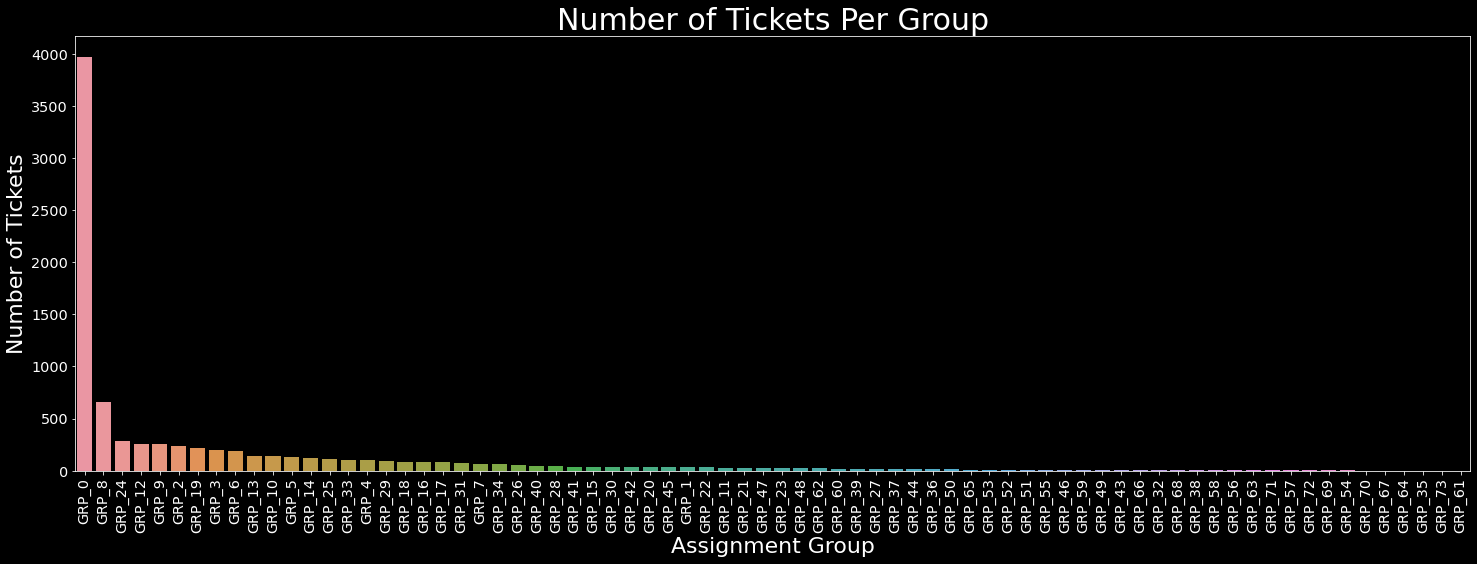

In [42]:
series = data['assignment_group'].value_counts()
plt.figure(figsize=(25,8))
sns.barplot(x = series.index, y = series.values)
plt.xticks(rotation='vertical')
plt.title('Number of Tickets Per Group', fontsize=30)
plt.xlabel('Assignment Group', fontsize=22)
plt.ylabel('Number of Tickets', fontsize=22)
plt.show()

Data is highly imbalanced
Most of the tickets are assigned to Group 0
We may need to remove some groups and their records
We also need to look for different cluster in Group 0

# 9. Displaying Most important words from Descriptions 

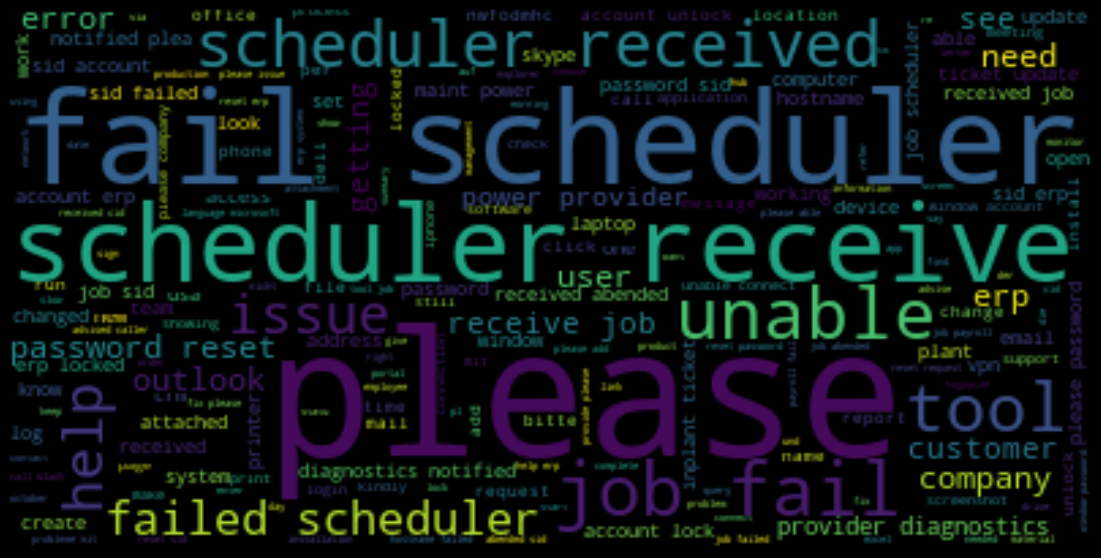

In [43]:
#Fetching all the words from the description in a string
text = data['cleaner_description'].to_string(header=False,index=False).replace('\n','').replace('\\n','').replace('\r','').replace('\\r','')
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see that following are the some important words from cleaner descriptions
Job
Scheduler
Password

# Hardware related tickets are assigned to specific groups

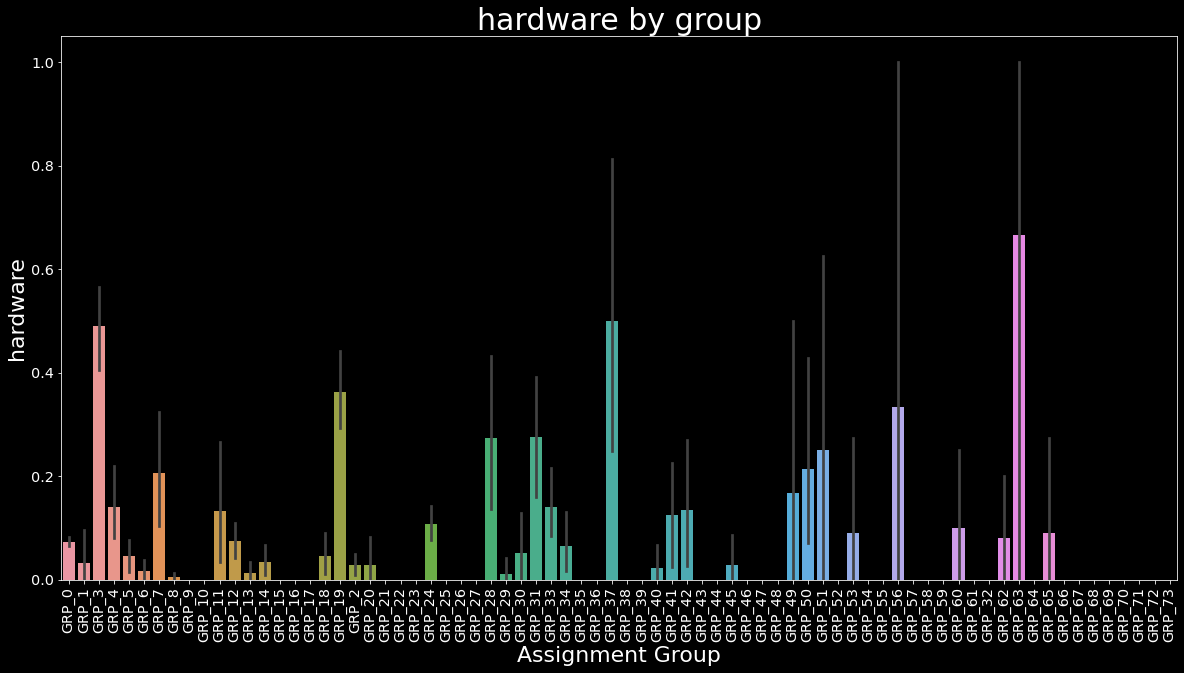

In [44]:
hardware = ['monitor', 'printer', 'xerox', 'badge', 'pc', 
            'av system', 'keyboard', 'computer', 
            'phone', 'laptop', 'usb', 'wifi', 
            'tablet', 'docking station', 'machine', 
            'mouse', 
            'speaker']
data['hardware'] = data['cleaner_short_description'].apply(lambda x: sum([1 if y in str(x) else 0 for y in hardware]))
sns.barplot(y=data['hardware'], x = data["assignment_group"])
plt.title('hardware by group', fontsize=30)
plt.xlabel('Assignment Group', fontsize=22)
plt.ylabel('hardware', fontsize=22)
plt.xticks(rotation='vertical')
plt.show()

# 12. Payment issues assigned by group

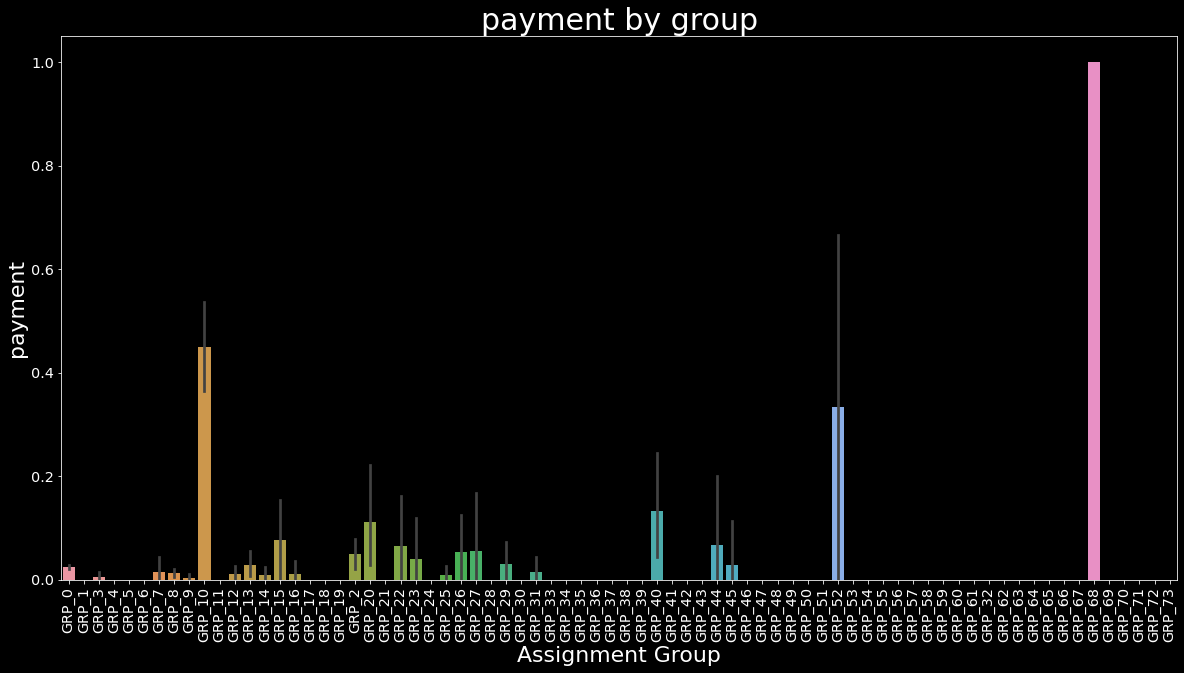

In [45]:
payment = ['payment', 'expense', 'balance', 'tax', 'vat', 'credit limit', 'currency', 'accounts', 'payroll']
data['payment'] = data['cleaner_short_description'].apply(lambda x: sum([1 if y in str(x) else 0 for y in payment]))
sns.barplot(y=data['payment'], x = data["assignment_group"])
plt.title('payment by group', fontsize=30)
plt.xlabel('Assignment Group', fontsize=22)
plt.ylabel('payment', fontsize=22)
plt.xticks(rotation='vertical')
plt.show()

# 13. Network issues assigned by group

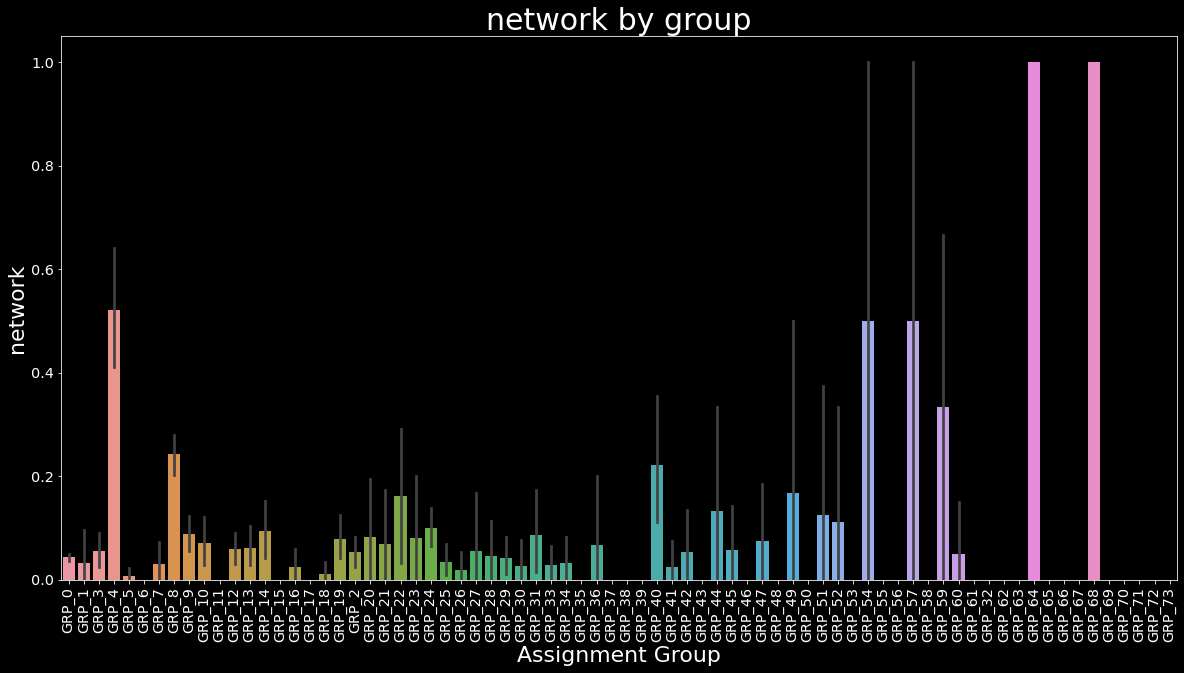

In [46]:
network = ['wireless', 'port', 'network', 'wifi', 'access point', 'internet service', 'connectivity issue','router','wlan','circuit']
data['network'] = data['cleaner_short_description'].apply(lambda x: sum([1 if y in str(x) else 0 for y in network]))
sns.barplot(y=data['network'], x = data["assignment_group"])
plt.title('network by group', fontsize=30)
plt.xlabel('Assignment Group', fontsize=22)
plt.ylabel('network', fontsize=22)
plt.xticks(rotation='vertical')
plt.show()